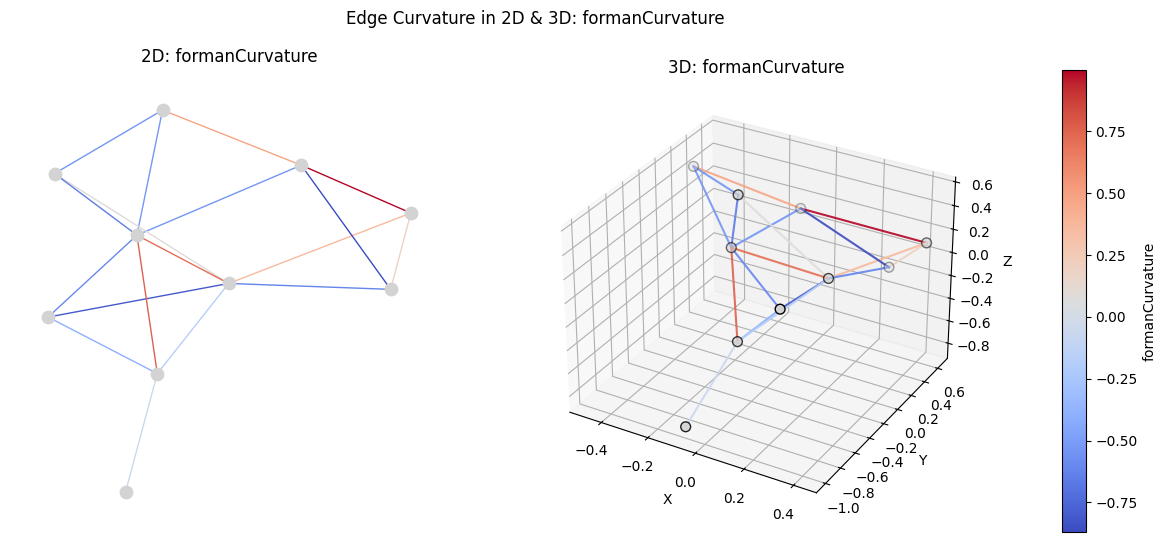

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_graph_2d_and_3d_curvature(G, curvature_attr="formanCurvature"):
    """
    Plots the same graph in two subplots:
      - 2D (left) with nx.kamada_kawai_layout
      - 3D (right) with nx.spring_layout(dim=3)
    Colors edges by the same curvature scale.
    """

    # 1) Extract curvature array from the graph's edges
    edge_curvs = nx.get_edge_attributes(G, curvature_attr)
    if not edge_curvs:
        print(f"Warning: No edge attribute '{curvature_attr}' found.")
        return

    # We want to unify the color scale for both 2D & 3D
    curv_values = np.array(list(edge_curvs.values()))
    vmin, vmax = curv_values.min(), curv_values.max()
    if vmin == vmax:  # if all curvatures identical, offset a bit
        vmin, vmax = vmin - 0.5, vmax + 0.5

    # 2) Prepare the figure with two subplots
    fig = plt.figure(figsize=(14, 6))
    ax2d = fig.add_subplot(121)
    ax3d = fig.add_subplot(122, projection='3d')

    ###########################
    # LEFT SUBPLOT (2D)
    ###########################
    pos2d = nx.kamada_kawai_layout(G)   # or nx.spring_layout(G, seed=...)
    # Build a list of edge colors from each edge's curvature
    edges_2d = []
    edge_colors_2d = []
    for (u, v) in G.edges():
        c = G[u][v][curvature_attr]
        frac = (c - vmin)/(vmax - vmin)
        color = plt.cm.coolwarm(frac)
        edges_2d.append((u, v))
        edge_colors_2d.append(color)

    # Draw nodes (in some neutral color)
    nx.draw_networkx_nodes(
        G, 
        pos2d, 
        node_size=80, 
        node_color='lightgray', 
        ax=ax2d
    )
    # Draw edges with the curvature colormap
    nx.draw_networkx_edges(
        G,
        pos2d,
        edgelist=edges_2d,
        edge_color=edge_colors_2d,
        ax=ax2d
    )
    ax2d.set_title(f"2D: {curvature_attr}")
    ax2d.axis("off")

    ###########################
    # RIGHT SUBPLOT (3D)
    ###########################
    pos3d = nx.spring_layout(G, dim=3, seed=42)  # or kamada_kawai in 3D if you prefer
    # We'll manually draw edges in 3D
    for (u, v) in G.edges():
        c = G[u][v][curvature_attr]
        frac = (c - vmin)/(vmax - vmin)
        color = plt.cm.coolwarm(frac)
        # each edge is a line in 3D
        xline = [pos3d[u][0], pos3d[v][0]]
        yline = [pos3d[u][1], pos3d[v][1]]
        zline = [pos3d[u][2], pos3d[v][2]]
        ax3d.plot(xline, yline, zline, color=color, alpha=0.9)

    # Optionally, also scatter-plot the nodes
    node_xyz = np.array([pos3d[n] for n in G.nodes()])
    ax3d.scatter(
        node_xyz[:,0],
        node_xyz[:,1],
        node_xyz[:,2],
        s=50, 
        c='lightgray',
        edgecolors='black'
    )

    ax3d.set_title(f"3D: {curvature_attr}")
    # Turn off 3D grid lines, if you like
    ax3d.set_xlabel("X")
    ax3d.set_ylabel("Y")
    ax3d.set_zlabel("Z")

    # Make sure the 3D subplot has enough room
    # you can do e.g. ax3d.axis("off") but 3D doesn't fully support that
    # or do ax3d.set_box_aspect((1,1,1)) for a cubic aspect ratio

    # 3) Add a single colorbar for both subplots
    #    We'll create a ScalarMappable from vmin..vmax with the same colormap
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.coolwarm, 
        norm=plt.Normalize(vmin=vmin, vmax=vmax)
    )
    sm.set_array([])  # avoids a matplotlib warning
    cbar = fig.colorbar(sm, ax=[ax2d, ax3d], fraction=0.03, pad=0.08)
    cbar.set_label(curvature_attr)

    plt.suptitle(f"Edge Curvature in 2D & 3D: {curvature_attr}")
    plt.show()

########################################################
# Example usage:
if __name__ == "__main__":
    # Create a sample graph
    G = nx.erdos_renyi_graph(10, 0.3, seed=1)
    # Assign some random "formanCurvature" values
    for (u, v) in G.edges():
        G[u][v]["formanCurvature"] = np.random.uniform(-1, 1)

    # Call function
    plot_graph_2d_and_3d_curvature(G, curvature_attr="formanCurvature")
